In [1]:
library(phangorn)
library(ape)
library(pheatmap)
library(RColorBrewer)

Loading required package: ape



In [2]:
# Custom Hamming distance function that handles NAs (by not computing distance at a position unless both cell types are not NA)
hamming_na <- function(x, y) {
  non_na_positions <- !is.na(x) & !is.na(y)
  sum(x[non_na_positions] != y[non_na_positions])
}

# Single donor

## Single donor tree

In [3]:
# Set the donor
donor <- "Hst41"

# Read in mutation matrix (cell type by mutation)
filepath <- paste0('/lustre/scratch126/cellgen/team205/jc48/jupyter/SComatic/mutation_matrices/neural_outgroup/', donor, '.csv')
mat <- read.table(filepath, sep = ',', header = TRUE)
mat <- mat[, -1] # remove the index column
mat <- mat[, order(colnames(mat))] # order column names alphabetically
print(dim(mat))
head(mat)

[1] 310  11


,AtrialCardiomyocytesLeft,AtrialCardiomyocytesRight,AtrioventricularNodeCardiomyocytes,Neural,SinoatrialNodeCardiomyocytes,VentricularCardiomyocytesLeftCompact,VentricularCardiomyocytesLeftTrabeculated,VentricularCardiomyocytesRightCompact,VentricularCardiomyocytesRightTrabeculated,VentricularConductionSystemDistal,VentricularConductionSystemProximal
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,NA,0,0,0,0,0,0,1,0
2,0,0,0,0,NA,0,0,0,0,NA,0
3,0,0,NA,0,0,0,0,0,0,NA,0
4,0,0,NA,NA,0,0,0,0,0,1,0
5,0,0,NA,0,0,0,0,0,0,0,0
6,0,0,NA,0,1,0,0,0,0,0,0


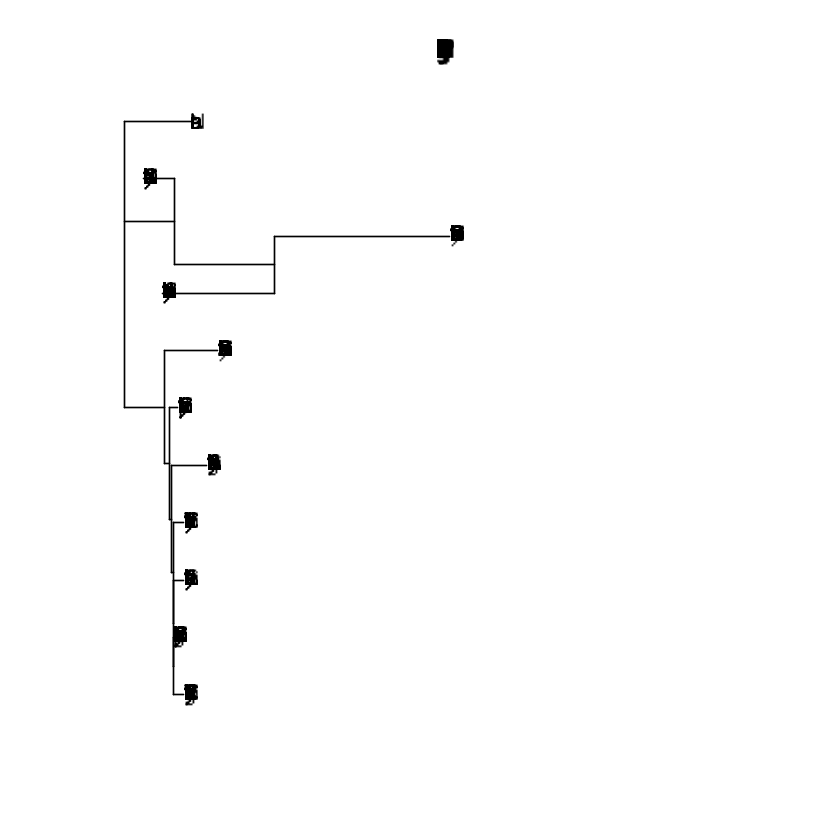

In [4]:
# Open a PDF device with specified width and height (in inches)
#pdf("phylogenetic_tree.pdf", width=8, height=6)

# Make distance matrix
dm <- as.dist(outer(1:ncol(mat), 1:ncol(mat), Vectorize(function(i, j) hamming_na(mat[, i], mat[, j]))))

# Construct tree
tree <- NJ(dm)

# Add the col names of mat as tip labels to the tree
tree$tip.label <- colnames(mat)

# Plot tree
# Note: Ensure 'root' function and 'NJ' function are properly loaded or available in your environment
plot(root(tree, outgroup='Neural'))

# Add title to the plot
# Note: Replace 'donor' with the actual variable or a specific string if 'donor' is not defined
title(paste0("Phylogenetic tree for ", donor))

# Close the PDF device to finalize the file
#dev.off()


# Multiple donors

## individual trees

In [5]:
# Load necessary libraries
library(ape) # For phylogenetic analysis
library(phangorn) # For constructing and plotting the tree
library(utils) # For reading files

# Function to calculate Hamming distance, handling NA values
hamming_na <- function(x, y) {
  sum(x != y, na.rm = TRUE)
}

# Initialize the list of data frames
list_of_data_frames <- list()

# Just read in these 5 files
filenames <- c("2023-05-22-C98.csv","2023-05-22-C87.csv","2023-05-22-Hst33.csv","2023-05-22-C92.csv","2023-05-22-Hst41.csv")


# Loop through the CSV files
for (filename in filenames) {
    
  file <- paste0(path = "/lustre/scratch126/cellgen/team205/jc48/jupyter/SComatic/mutation_matrices/neural_outgroup/",filename)
  # Read in mutation matrix
  mat <- read.csv(file, header = TRUE)
  mat <- mat[, -1] # remove the first column, assuming it's an index column


  # Identify columns starting with 'X'
  vcs_cols <- grep("^VentricularCond", names(mat), value = TRUE)

  # Add a new column to the data frame by summing rows across X columns
  # na.rm = TRUE ensures that NA values are ignored in the sum
  mat$CCS_VentricularConductionSystem <- rowSums(mat[vcs_cols], na.rm = TRUE)

  # Now drop the 'X' columns
  mat <- mat[ , !names(mat) %in% vcs_cols]


  # Identify columns ending with 'X'
  node_cols <- grep("NodeCardiomyocytes$", names(mat), value = TRUE)

  # Add a new column to the data frame by summing rows across X columns
  # na.rm = TRUE ensures that NA values are ignored in the sum
  mat$CCS_PacemakerCardiomyocytes <- rowSums(mat[node_cols], na.rm = TRUE)

  # Now drop the 'X' columns
  mat <- mat[ , !names(mat) %in% node_cols]


    
  # Order the columns alphabetically
  mat <- mat[, order(colnames(mat))]

  # Extract the donor name from the filename
  donor <- gsub(".*-(.*)\\.csv$", "\\1", basename(file))
  print(donor)

  pdf(paste0("phylogenetic_tree___",donor,".pdf"), width=8, height=6)

  # Make distance matrix
  dm <- as.dist(outer(1:ncol(mat), 1:ncol(mat), Vectorize(function(i, j) hamming_na(mat[ , i], mat[ , j]))))

  # Construct tree using neighbor joining method
  tree <- nj(dm)

  # Add the col names of mat as tip labels to the tree
  tree$tip.label <- colnames(mat)

  # Check for the presence of specific cell types and plot accordingly
  if ("Neural" %in% colnames(mat)) {
    plot(root(tree, outgroup = "Neural"), main = paste0("Phylogenetic tree for donor: ", donor))
  } else if ("NeuronPrecursors" %in% colnames(mat)) {
    plot(root(tree, outgroup = "NeuronPrecursors"), main = paste0("Phylogenetic tree for donor: ", donor))
  } else {
    plot(tree, main = paste0("Phylogenetic tree for donor: ", donor)) # Plot without specifying an outgroup if none of the specific types are present
  }
  dev.off()
}


[1] "C98"
[1] "C87"
[1] "Hst33"
[1] "C92"
[1] "Hst41"


# consensus tree

In [6]:
# Initialize the list of data frames
list_of_data_frames <- list()

# List all CSV files in the mutation_matrices directory
#files <- list.files(path = "/lustre/scratch126/cellgen/team205/jc48/jupyter/SComatic/mutation_matrices/neural_outgroup/", pattern = "*.csv", full.names = TRUE)

files <- list.files(path = "/nfs/team205/jc48/projects/fetal/code/SComatic/mutation_matrices/neural_outgroup/", 
                    pattern = "\\d{4}-\\d{2}-\\d{2}-.*\\ChromaffinCells.csv$", full.names = TRUE)

print(files)

# Initialize the list of donors
donors <- list()

# Loop through the CSV files
for (file in files) {
  # Read in mutation matrix
  mat <- read.table(file, sep = ',', header = TRUE)
  mat = mat[, -1] # remove the index column

  # Order the columns alphabetically
  mat <- mat[, order(colnames(mat))]

  # Add the ordered data frame to the list of data frames
  list_of_data_frames <- append(list_of_data_frames, list(mat))

  # Extract the donor name from the filename and add it to the list of donors
  donor <- gsub("\\..*", "", basename(file))
  donors <- append(donors, donor)
}

# Print the dimensions of all data frames in the list
lapply(list_of_data_frames, dim)

# Convert elements in the list to characters
donors <- lapply(donors, as.character)

# Use regular expression to extract the donor information
donors <- sub(".+-([A-Za-z0-9]+)ChromaffinCells", "\\1", unlist(donors))

# Print the result
print(donors)


# Initialize the merged matrix
merged_mat <- NULL

# Loop through the list of data frames and concatenate them
for (mat in list_of_data_frames) {
  if (is.null(merged_mat)) {
    merged_mat <- mat
  } else {
    merged_mat <- rbind(merged_mat, mat)
  }
}

mat <- merged_mat
head(mat)

[1] "/nfs/team205/jc48/projects/fetal/code/SComatic/mutation_matrices/neural_outgroup//2023-05-22-C87ChromaffinCells.csv"  
[2] "/nfs/team205/jc48/projects/fetal/code/SComatic/mutation_matrices/neural_outgroup//2023-05-22-C92ChromaffinCells.csv"  
[3] "/nfs/team205/jc48/projects/fetal/code/SComatic/mutation_matrices/neural_outgroup//2023-05-22-C98ChromaffinCells.csv"  
[4] "/nfs/team205/jc48/projects/fetal/code/SComatic/mutation_matrices/neural_outgroup//2023-05-22-Hst33ChromaffinCells.csv"
[5] "/nfs/team205/jc48/projects/fetal/code/SComatic/mutation_matrices/neural_outgroup//2023-05-22-Hst41ChromaffinCells.csv"


[[1]]
[1] 12 11

[[2]]
[1] 21 11

[[3]]
[1] 26 11

[[4]]
[1] 677  11

[[5]]
[1] 82 11

[1] "C87"   "C92"   "C98"   "Hst33" "Hst41"


,AtrialCardiomyocytesLeft,AtrialCardiomyocytesRight,AtrioventricularNodeCardiomyocytes,ChromaffinCells,SinoatrialNodeCardiomyocytes,VentricularCardiomyocytesLeftCompact,VentricularCardiomyocytesLeftTrabeculated,VentricularCardiomyocytesRightCompact,VentricularCardiomyocytesRightTrabeculated,VentricularConductionSystemDistal,VentricularConductionSystemProximal
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,NA,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,NA,NA,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0
5,0,1,NA,NA,0,0,0,0,0,0,0
6,0,0,0,NA,1,0,0,0,0,0,0


In [7]:
# Identify columns starting with 'X'
vcs_cols <- grep("^VentricularCond", names(mat), value = TRUE)

# Add a new column to the data frame by summing rows across X columns
# na.rm = TRUE ensures that NA values are ignored in the sum
mat$CCS_VentricularConductionSystem <- rowSums(mat[vcs_cols], na.rm = TRUE)

# Now drop the 'X' columns
mat <- mat[ , !names(mat) %in% vcs_cols]

In [8]:
# Identify columns ending with 'X'
node_cols <- grep("NodeCardiomyocytes$", names(mat), value = TRUE)

# Add a new column to the data frame by summing rows across X columns
# na.rm = TRUE ensures that NA values are ignored in the sum
mat$CCS_PacemakerCardiomyocytes <- rowSums(mat[node_cols], na.rm = TRUE)

# Now drop the 'X' columns
mat <- mat[ , !names(mat) %in% node_cols]

In [9]:
# View the updated dataframe
head(mat)

,AtrialCardiomyocytesLeft,AtrialCardiomyocytesRight,ChromaffinCells,VentricularCardiomyocytesLeftCompact,VentricularCardiomyocytesLeftTrabeculated,VentricularCardiomyocytesRightCompact,VentricularCardiomyocytesRightTrabeculated,CCS_VentricularConductionSystem,CCS_PacemakerCardiomyocytes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,NA,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0
3,0,0,NA,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1
5,0,1,NA,0,0,0,0,0,0
6,0,0,NA,0,0,0,0,0,1


## consensus tree - bootstrapped

In [10]:
pdf(paste0("phylogenetic_tree___consensus.pdf"), width=8, height=6)

#make distance matrix
dm <- as.dist(outer(1:ncol(mat), 1:ncol(mat), Vectorize(function(i, j) hamming_na(mat[ , i], mat[ , j]))))

#construct tree
tree <- NJ(dm)

#add the col names of mat_t as tip labels to the tree
tip_labels=colnames(mat)
tree$tip.label <- tip_labels

# Bootstrap
set.seed(123) # for reproducibility

bstrees <- boot.phylo(tree, t(mat), B = 100, 
                      FUN = function(x) NJ(dist(x, method = "binary")), trees = TRUE)$trees
plotBS(root(tree, outgroup='ChromaffinCells'), bstrees, "phylogram", p=0)                                                                                                                 
                                                        
# Add title to the plot
title(paste0("Phylogenetic tree for donors: ", paste(donors, collapse = ", ")))

dev.off()

Running bootstraps:       100 / 100
Calculating bootstrap values... done.


png 
  2